In [1]:
from PIL import Image, ImageDraw
#%matplotlib nbagg

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

In [4]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

In [5]:
from IPython import display
import gym
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import tensorflow
import tensorflow.compat.v1 as tf
import tensorflow.keras.layers as tl
import os
tf.disable_eager_execution()
plt.rcParams.figsize = (32, 40)

In [6]:
env = gym.make('CartPole-v0')

In [ ]:
obs = env.reset()
obs

[ Положение телеги, скорость телеги, угол дышла, угловая скорость дышла ]

In [ ]:
plt.imshow(env.render("rgb_array"))

In [ ]:
env.observation_space

In [ ]:
env.action_space.n

2 действия. ускорение вправо или влево

In [ ]:
action = 1 # ускорение вправо

In [ ]:
obs, reward, done, info = env.step(action)
obs

In [ ]:
obs[1]

In [ ]:
reward

In [ ]:
done

In [ ]:
info

In [ ]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

In [ ]:
img = render_cart_pole(env, obs)

In [ ]:
totals = []
for episode in range(500):
    episode_rewards = 0 #собираем награду
    obs = env.reset() #перезагружаем среду каждый эпизод
    for step in range(1000):
        #plt.gca().clear()
        
        action = basic_policy(obs) # 1 | 0
        obs, reward, done, info = env.step(action)
        episode_rewards += reward #награды за эпизод
        
        #plt.imshow(env.render("rgb_array"))
        #display.clear_output(wait=True)
        #display.display(plt.gcf())
        
        if done: #если угол слишком большой и мы проиграли
            break
    
    totals.append(episode_rewards) #составляем сумму наград

In [ ]:
img = render_cart_pole(env, obs)
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1

    obs, reward, done, info = env.step(action)
    if done:
        break

import time
time.sleep(2)
env.close()

In [ ]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

# Использование нейронной сети

In [6]:
import tensorflow
import tensorflow.compat.v1 as tf
import tensorflow.keras.layers as tl
tf.disable_eager_execution()

In [7]:
# 1. Определение архитектуры нейронной сети
n_inputs = 4 # env.observation_space.shape[0] state_dim
n_hidden = 4 # нет нужды в большем количестве нейронов
n_outputs = 1 # выдает вероятность ускорения влево

In [8]:
initializer = tf.variance_scaling_initializer()

# 2. Построение нейронной сети. Многослойный перцептрон с единственным выходом
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden = tf.layers.dense(X, n_hidden, activation='relu', kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits) # probability of action 0 (left)

#3. Выбор случайного действия на основе оценочных вероятностей
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1) # вызов функции для выбора случайного действия



Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.random.categorical` instead.


In [9]:
# Оценка действий / градиенты политики
y = 1. - tf.to_float(action)

learning_rate = 0.01

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)

gradients = [grad for grad, variable in grads_and_vars]

Instructions for updating:
Use `tf.cast` instead.


In [ ]:
cross_entropy

In [ ]:
optimizer

In [ ]:
grads_and_vars

In [10]:
gradient_placeholders = [] # список обновленных градиентов
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape = grad.get_shape())
    gradient_placeholders.append(gradient_placeholder) 
    grads_and_vars_feed.append((gradient_placeholder, variable))

training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
gradient_placeholders

In [ ]:
grads_and_vars_feed

In [ ]:
training_op

In [ ]:
init

In [ ]:
saver

In [11]:
# обозначение функции наград со скидкой
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [ ]:
discount_rewards([10, 0, -50], discount_rate = 0.8)
# поскольку на итог не влияет только последнее действие, следствием идут и 
# предпоследние шаги, поэтому награда для них изменяется со скидкой

In [ ]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

Все нормализованные действия [-0.28435071, -0.86597718, -1.18910299] из первого эпизода [10, 0, -50] - отрицательные, так как этот эпизод гораздо хуже второго [10, 20] с нормированными результатами [1.26665318, 1.0727777]

In [ ]:
action

In [ ]:
n_iterations = 250 # количество итераций обучения
n_max_steps = 1000 # максимальное количество шагов на эпизод
n_games_per_update = 10 # обучение политики каждые 10 эпизодов
save_iterations = 10 # сохранение модели каждые 10 итераций обучения
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    
    for iteration in range(n_iterations):
        
        all_rewards = [] # все последовательности необработанных наград для каждого эпизода
        
        all_gradients = [] # градиенты, сохраняемые на каждом шаге каждого эпизода
        
        for game in range(n_games_per_update):
            
            current_rewards = [] # все необработанные награды из текущего эпизода
            
            current_gradients = [] # все градиенты из текущего эпизода
            
            obs = env.reset()
            for step in range(n_max_steps):
                
                action_val, gradients_val = sess.run([action, gradients],
                                                    feed_dict = {X: obs.reshape(1, n_inputs)} # одно наблюдение
                                                    )
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                
                if done:
                    break
            
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        # в этой точке мы прогнали политику для 10 эпизодов и готовы к обновлению
        # политики, используя описанный ранее алгоритм
        
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
        
        feed_dict = {}
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
        # умножение градиентов на оценки действий и вычисление среднего
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                     for game_index, rewards in enumerate(all_rewards)
                                     for step, reward in enumerate(rewards)],
                                     axis=0)
            feed_dict[grad_placeholder] = mean_gradients
        sess.run(training_op, feed_dict = feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, './my_model/my_policy_net_pg.ckpt')

In [ ]:
env.close()

Каждая итерация обучения начинается с прогона политики для 10 эпизодов (с максимум 1 000 шагов на эпизод во избежание бесконечного выполнения). На каждом шаге мы также вычисляем градиенты, делая вид, что выбранное действие было наилучшим. После завершения 10 эпизодов мы вычисляем оценки действий с использованием функции discount_and_ normalize_rewards(). Мы проходим через каждую обучаемую переменную по всем эпизодам и всем шагам, чтобы умножить каждый вектор- градиент на соответствующую ему оценку действия, и вычисляем среднее результирующих градиентов. Наконец, мы запускаем операцию обучения, передав ей усредненные градиенты (по одному на обучаемую переменную). Мы также сохраняем модель каждые 10 операций обучения.

In [ ]:
frames = render_policy_net("./my_model/my_policy_net_pg.ckpt", action, X, n_max_steps=1000)
video = plot_animation(frames)
plt.show()

In [ ]:
writergif = animation.PillowWriter(fps=30, bitrate=1800) 
video.save('./gym/cartpole4.gif', writer=writergif, dpi=2)

# Ms. Pac-Man

In [12]:
env = gym.make('MsPacman-v0')
obs = env.reset()
obs.shape # высота, ширина, каналы (цвет?)

(210, 160, 3)

In [13]:
env.action_space # вызможности для движения ПакМана

Discrete(9)

In [9]:
env.action_space.n

9

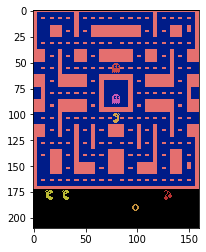

In [10]:
plt.imshow(obs)

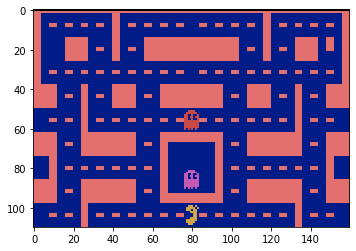

In [11]:
plt.imshow(obs[0:110, 0:160, :3]) # высота

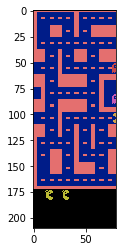

In [12]:
plt.imshow(obs[0:210, 0:80, :]) #ширина

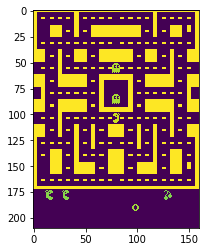

In [13]:
plt.imshow(obs[0:210, 0:160, 0]) # цветовой канал

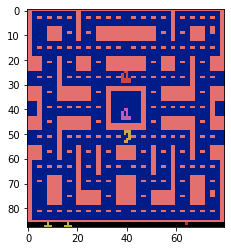

In [14]:
plt.imshow(obs[1:176:2, ::2])

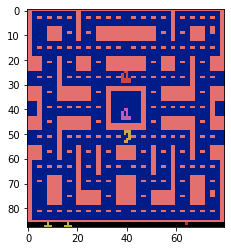

In [15]:
plt.imshow(obs[1:176:2, ::2, :])
#для высоты берем с первой по 176 строчку с шагом два
# для ширины берем каждую строчку через одну

In [14]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # обрезать размер и сжать
    img = img.sum(axis=2) # перевод в greyscale
    img[img==mspacman_color] = 0 # увеличиваем контрастность
    img = (img // 3 - 128).astype(np.int8) # нормализуем от -128 до 127
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

In [15]:
img.shape

(88, 80, 1)

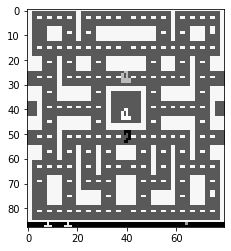

In [16]:
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap='gray')

### Построение

In [17]:
reset_graph()
input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8, 8), (4, 4), (3, 3)]
conv_strides = [4, 2, 1]
conv_paddings = ['SAME'] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10 # conv3 имеет 64 карты, каждая 11х10
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n
initializer = tf.variance_scaling_initializer()

In [18]:
def q_network(X_state, name):
    prev_layer = X_state / 128
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                                    conv_n_maps, conv_kernel_sizes, conv_strides,
                                    conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(prev_layer, filters=n_maps, kernel_size=kernel_size,
                                  strides=strides, padding=padding, activation=activation,
                                  kernel_initializer=initializer)
            last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
            
            hidden = tf.layers.dense(last_conv_layer_flat, n_hidden, activation = hidden_activation,
                                    kernel_initializer = initializer)
            
            outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
            
            
        trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
            
        trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
            
        return outputs, trainable_vars_by_name

In [19]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


In [20]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1]) # создание заполнителя y
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)
    # потеря является квадратичной для небольших ошибок и линейной для крупных ошибок
    # сделано в целях уменьшения влияния крупных ошибок и для стабилизации обучения
    
    # переменная global_step - необучаемая переменная для отслеживания шага обучения
    # задаем оптимизатор, операцию init и saver
    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True) # Оптимизатор на основе 
                                                          # ускоренного градиента Нестерова
                                                          # для сведения потерь к минимуму
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [178]:
tf.train.MomentumOptimizer?

### Еще пара вспомогательных инструментов

In [21]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [22]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

def sample_memories(batch_size):
    cols = [[], [], [], [], []] # состояние, действие, награда, следующее состояние, продолжение / завершение (done)
    
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

##### Агент для наблюдения за игрой

In [23]:
# e-жадная политика, постепенное уменьшение e от 1.0 до 0.1
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # случайное действие
    else:
        return np.argmax(q_values)


### Выполнение

In [24]:
n_steps = 4000000 # 4 мил - количество шагов обучения
training_start = 10000 # начать обучение после 10 тыс шагов
training_interval = 4 # запускать шаг обучения каждые 4 итерации игры
save_steps = 1000 # сохранять модель каждые 1000 шагов игры
copy_steps = 10000 # копировать динамическую сеть DQN в целевую DQN каждые 10000 шагов обучения
video_steps = 10000

discount_rate = 0.99
skip_start = 90 # пропускать начало каждой игры (время ожидания)
batch_size = 50
iteration = 0 # итерации игры
checkpoint_path = './pacman/my_dqn.ckpt'
done = True # среда нуждается в сбросе
model_video_list = []

In [25]:
video_steps = 10000
video_steps2 = 100000

In [26]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

In [101]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + '.index'):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration+=1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: #игра окончена, начать заново
            obs = env.reset()
            for skip in range(skip_start): # пропускать начало каждой игры
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)
        # динамическая сеть DQN оценивает, что делать
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)
        
        # Динамическая сеть DQN играет
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)
        
        # запомнить произошедшее только что
        replay_memory.append((state, action, reward, next_state, 1.0-done))
        state = next_state
        
        # подсчет статистики для промежуточных итогов
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0
        
        if iteration < training_start or iteration % training_interval != 0:
            continue # обучать только после стадии разогрева или через определенные интервалы
        
        # выбрать запомненные данные и использовать целевую сеть DQN для выработки целевой ценности
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (sample_memories(batch_size))
        next_q_values = target_q_values.eval(feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * max_next_q_values * discount_rate
        
        # обучить динамическую сеть DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})
        
        # регулярно копировать динамическую сеть DQN в целевую DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()
        
        # регулярно сохранять
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)
            
            #закомментировано после 10000
            #saver.save(sess, './pacman/futurevideo/my_dqn{}.ckpt'.format(step))
            #model_video_list.append('./pacman/futurevideo/my_dqn{}.ckpt'.format(step))
            
        #сохранение моделей для видео
        if (step % video_steps == 0) & (step < 100000):
            saver.save(sess, './pacman/futurevideo/my_dqn{}.ckpt'.format(step))
            model_video_list.append('./pacman/futurevideo/my_dqn{}.ckpt'.format(step))
        
        if (step % video_steps2 == 0) & (step >= 100000):
            saver.save(sess, './pacman/futurevideo/my_dqn{}.ckpt'.format(step))
            model_video_list.append('./pacman/futurevideo/my_dqn{}.ckpt'.format(step))

INFO:tensorflow:Restoring parameters from ./pacman/my_dqn.ckpt
Iteration 223384	Training step 51452/4000000 (1.3)%	Loss 0.753191	Mean Max-Q 0.689832    

KeyboardInterrupt: 

In [56]:
fnames = os.listdir(checkpoint_path2)
fnames = fnames[38:]
fnames = list(set([i.split('.')[0] for i in fnames]))
fnames

['my_dqn50000',
 'my_dqn40000',
 'my_dqn7000',
 'my_dqn20000',
 'my_dqn10000',
 'my_dqn30000']

In [66]:
%matplotlib inline

checkpoint_path2 = './pacman/checkvideo/'
index2 = '/my_dqn10000.ckpt'
n_max_steps = 100000
frames=[]
with tf.Session() as sess:
    for fname in fnames:
        
        saver.restore(sess, checkpoint_path2 + fname + '.ckpt')

        obs = env.reset()
        for step in range(n_max_steps):
            state = preprocess_observation(obs)

            # Online DQN evaluates what to do
            q_values = online_q_values.eval(feed_dict={X_state: [state]})
            action = np.argmax(q_values)

            # Online DQN plays
            obs, reward, done, info = env.step(action)
    
            img = env.render(mode="rgb_array")
            #img = preprocess_observation(obs).reshape(88, 80)
            frames.append(img)

            if done:
                break

        video = plot_animation(frames)
        writergif = animation.PillowWriter(fps=15, bitrate=1800) 
        video.save('./pacman/video/{}.gif'.format(fname), writer=writergif, dpi=2)

INFO:tensorflow:Restoring parameters from ./pacman/checkvideo/my_dqn50000.ckpt


KeyboardInterrupt: 

In [64]:
animation.Animation.save?

In [37]:
%matplotlib inline

checkpoint_path2 = './pacman/checkvideo'
index2 = '/my_dqn10000.ckpt'
n_max_steps = 100000
frames=[]
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path2 + index2)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        #img = preprocess_observation(obs).reshape(88, 80)
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from ./pacman/checkvideo/my_dqn10000.ckpt


<IPython.core.display.Javascript object>


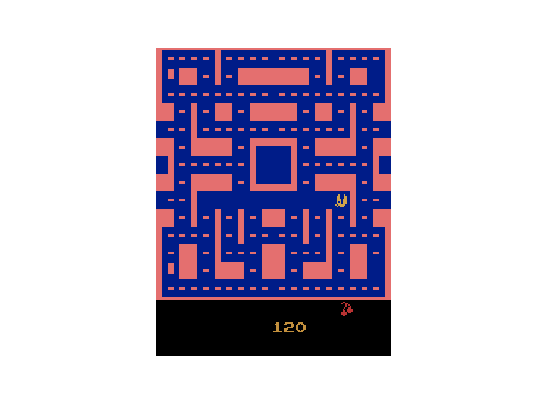

In [28]:
%matplotlib nbagg
plot_animation(frames)

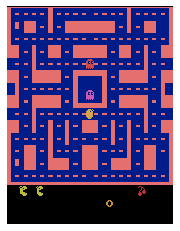

In [31]:
%matplotlib inline
video = plot_animation(frames)
writergif = animation.PillowWriter(fps=30, bitrate=1800) 
video.save('./pacman/video/cartpole4.gif', writer=writergif, dpi=2)

In [78]:
%matplotlib inline

Traceback (most recent call last):
  File "C:\Program Files (x86)\Soft data analyst\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Program Files (x86)\Soft data analyst\Anaconda\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


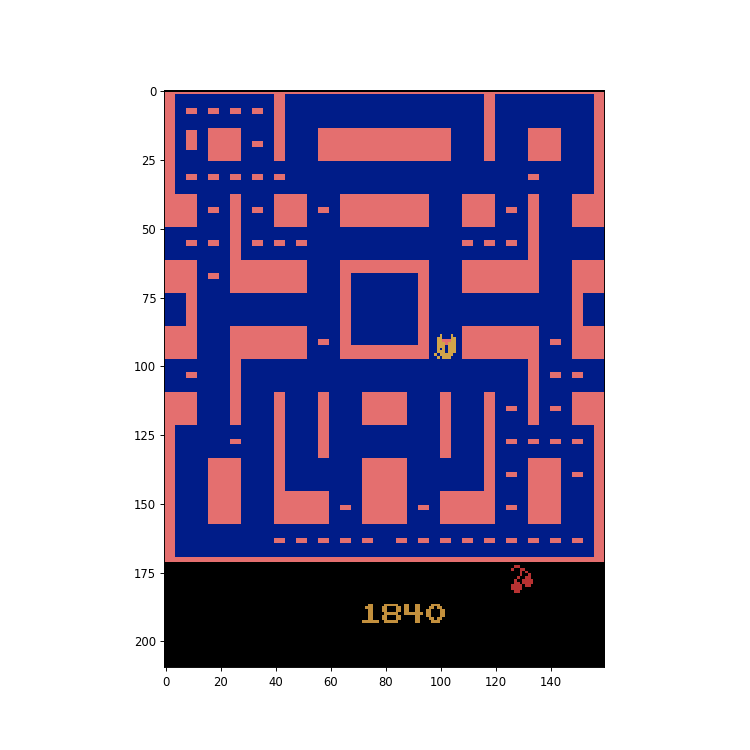

In [171]:
obs, reward, done, info = env.step(1)
fig = plt.figure(figsize=(9, 9))
#plt.imshow(env.render(mode="rgb_array"))
plt.imshow(obs)

In [68]:
def render_policy_net_pacman(model_path, action, X, n_max_steps = n_steps):
    frames = []
    env = gym.make("MsPacman-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

In [81]:
def render_policy_net_pacman(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("MsPacman-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

<IPython.core.display.Javascript object>


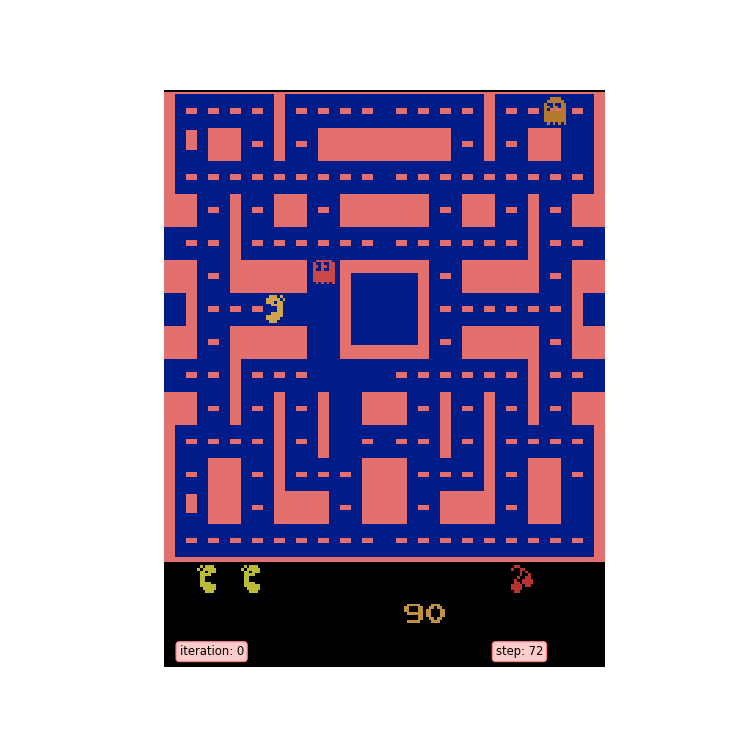

In [82]:
fig = plt.figure(figsize=(9, 9))
t = "iteration: {}".format(iteration)
t2 =  "step: {}".format(step)
plt.text(5, 205, t, fontsize=10, ha='left', rotation=0, bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ), wrap=True)
plt.text(120, 205, t2, fontsize=10, ha='left', rotation=0, bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ), wrap=True)
plt.axis('off')
plt.imshow(env.render(mode="rgb_array"))
plt.show()